# Predizione del contenuto idrico di un suolo agricolo attraverso il filtro di Kalman

## Obiettivo:

*   Sfruttando il filtro di Kalman, realizzare un sistema in grado di predirre l'evoluzione del contenuto idrico del suolo



## Definizione e identificazione del sistema
Il sistema di riferimento è costituito da un terreno agricolo, caratterizzato da:


*   Da un vettore di stati interni $x$
*   Da un vettore di input esogeni $u$, nel nostro caso la temperatura esterna, l'umidità e i mm di pioggia
*   Da un output misurabile $y$, nel nostro caso il contenuto idrico del suolo





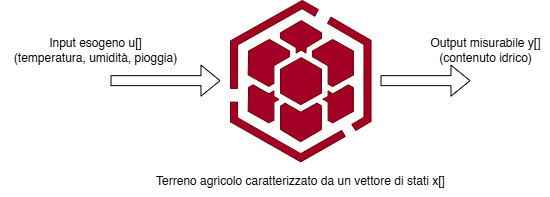

La dinamica interna del sistema può essere descritta dalle funzioni non lineari:

$x_{t}=f(x_{t-1},u_{t-1})$ l'**equazione di stato** che descrive come lo stato attuale dipende dallo stato precedente e dall'input precedente

$y_{t}=h(x_{t},u_{t})$ l'**equazione di output** che descrive come l'output dipende dallo stato corrente e dall'input corrente

Il modello matematico adottato è il modello del single-bucket, che in forma semplificata può essere scritto come:

$θ_{t+1}=θ_t+Δt ⋅ \frac{I_t-k_1T_{air_t}(1-H_t/100)-k_2max(0,θ_t-θ_{c_t})}{Z}$ con Δt come passo di discretizzazione

In questo modello abbiamo:


*   $θ$: contenuto idrico del suolo ($m^3/m^3$)
*   $θ_c$: capacità di campo ($m^3/m^3$)
*   $I$: input di pioggia ($m/s$)
*   $T_{air}$: temperatura dell'aria ($°C$)
*   $H$: umidità relativa (%)
*   $Z$: profondità del terreno (m)
*   $k_1$: coefficiente empirico ()
*   $k_2$: coefficiente di drenaggio ()



Riepilogando, avremo le seguenti variabili:

*   Input esogeno: $u_t=[T_{air},H,I]$
*   Variabili di stato: $x_t=[θ,θ_c,k_1,k_2,Z]$
*   Output: $y_t=[θ]$



### Equazione di output

L'equazione di output è particolarmente semplice nel nostro caso, siccome l'output non è altro che il primo elemento del vettore degli stati:

$h: y_t=x_t[0]$

### Equazione di stato

Per scrivere l'equazione di stato consideriamo che $x_t[0]$ (il contenuto idrico) è descritto dal modello scritto sopra, mentre gli altri stati $x_t[1]$, $x_t[2]$, $x_t[3]$ e $x_t[4]$ sono costanti:

$
f : x_{t+1}= \begin{pmatrix}
x_{t}[0]+Δt ⋅ \frac{u_t[2]-x_{t}[2]\cdot u_t[0]\cdot (1-u_t[1]/100)-x_{t}[3]\cdot max(0,x_{t}[0]-x_{t}[1])}{x_{t}[4]} \\
x_{t}[1] \\
x_{t}[2] \\
x_{t}[3] \\
x_{t}[4] \\
\end{pmatrix}
$


## Filtro di Kalman

Il filtro di Kalman è un algoritmo ricorsivo usato per stimare lo stato di un sistema dinamico nel tempo, combinando:

*   Il modello del sistema (equazioni di stato e di output)
*   Misure rumorose provenienti da sensori

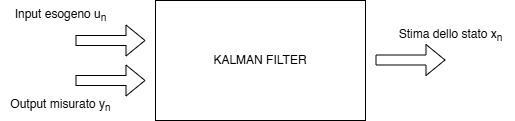



Il Filtro di Kalman è costituito da due fasi, `predict()` e `update()`:


*   Nella fase di `predict()`, partendo dallo stato precedente $x_{t-1}$ e dall'input precedente $u_{t-1}$ applichiamo la funzione $f(x_{t-1},u_{t-1})$, ottenendo una predizione dello stato successivo:
$x_{t}=f(x_{t-1},u_{t-1})$
*   Nella fase di `update()`, correggiamo questa predizione, applicando un algoritmo che tiene in considerazione la misura dell'output $y_{t}$ e due matrici Q e R: $\hat{x}_{t}=update(x_{t},y_{t},Q,R)$
*   Questa stima $\hat{x}_{t}$ prende in considerazione le incertezze legate al modello e alla misurazione. Possiamo perciò utilizzarla per trovare anche una stima del "vero" output: $\hat{y}_{t}=h(\hat{x}_{t})$
*   Nella fase di `update()`, l'algoritmo restituisce anche la matrice di covarianza P, che rappresenta l'incertezza sulla stima degli stati



### Cosa sono Q, R e P?



*   La matrice di covarianza P ha dimensione $dim_x × dim_x$ e rappresenta l'incertezza sulla stima degli stati $\hat{x}$. Viene generata ad ogni passo, e rappresenta l'affidabilità del filtro
*   La matrice di covarianza Q ha dimensione $dim_x × dim_x$ e rappresenta l'incertezza del modello. Un valora grande di Q rappresenta una bassa "fiducia" nel modello
*   La matrice di covarianza R ha dimensione $dim_y × dim_y$ e rappresenta l'incertezza sulla misura dell'ouput $y$. Un valora grande di R siginfica che la misura è rumorosa, e il filtro si affidera di più al modelo

I valori di Q e R possono essere trovati empiricamente, o impostati tramite *fine tuning*


Nel Filtro di Kalman classico si lavora con un sistema lineare. Siccome nel nostro caso la funzione $f(x,u)$ è non lineare, bisogna utilizzare un Filtro di Kalman Esteso (EKF), il quale segue lo stesso algoritmo del Filtro di Kalman classico, ma linearizzando il sistema ad ogni passo, nell'intorno dello stato attuale

Alla fine della predizione avremo escusivamente una stima corretta di $\hat{y}_t$. Per ottenere le predizioni dell'output fino a $\hat{y}_{t+k}$ dovremo rieseguire il Filtro di Kalman per altri $k$ passi, ma ciò non possibile, siccome avremmo bisogno anche delle successive misurazioni di $y$, di cui ovviamente non disponiamo.

La stretegia, perciò, è quella di eseguire per altri $k$ passi solamente la fase di `predict()`, senza correggere la predizione. Ovviamente, per grandi valori di $k$, le predizioni saranno via via meno affidabili. Notiamo però che la funzione `predict()` richiede anche gli input futuri (fino a $u_{t+k}$), perciò possiamo procedere nel seguente modo:


*   Assumiamo che l'input $u_t$ sia costante fino a $u_{t+k}$
*   Utilizziamo un modello per prevedere anche gli input futuri fino $u_{t+k}$



## Implementazione in Python

In [93]:
import numpy as np
from typing import Callable, Optional, Tuple
import plotly.graph_objects as go
import pandas as pd
import numdifftools as nd
import os

Iniziamo definendo i parametri che saranno utili nell'intero codice:

In [94]:
DIM_X = 6 # numero di stati
DIM_U = 3 # numero di input
DIM_Y = 1 # numero di output
Q_d = [ 1e-3] * DIM_X # covarianza sugli stati (valori sulla diagonale)
R_d = [ 1e2] * DIM_Y # covarianza sugli output (valori sulla diagonale)
P_d = [ 1] * DIM_X # matrice P iniziale (valori sulla diagonale)
X0 = [ -23.3 ,0.35 ,0.01 ,0.0001 ,0.01, -35] # vettore iniziale degli stati
TS = 30*60 # sampling time (in s) --> in pratica: ogni quanto ricevo il pacchetto con le misure
DT = 300 # precisione temporale (in s) --> in pratica: per "quanto tempo" assumo che le variabili di stato rimangano costanti

PATH = 'kalmanfilter.npz'

INF_LIMIT = -250
SUP_LIMIT = 0

Procediamo poi definendo le funzioni del nostro sistema, quindi la funzione di stato `f(x,u)` e la funzione di output `h(x,u)`. Nel caso della funziona di stato, siccome il modello descritto prima vale solamente per la variazione infinitesiamale $dt$, procederemo definendo `f_inf(x,u)` che calcola quanto variano gli stati durante `DT`, e poi con la funzione `f(x,u)` calcoleremo la variazione totale durante `TS`:

In [95]:
def f_inf(x, u): # x_next sulla variazione "infinitesimale" DT (ad es. 5 min)
    """
    Funzione di transizione dello stato.
    x: stato 5x1
    u: input esogeno 3x1
    """
    x_next = np.zeros_like(x)
    dx = [0] * DIM_X
    conv = 2.78e-7

    dx[0] = (x[4])*(conv*u[2] -x[2]*u[0]*(1-u[1]/100) -x[3]*np.maximum(0, x[0]-x[1]))
    dx[1] = -0.4
    dx[2] = 0
    dx[3] = 0
    dx[4] = 0
    dx[5] = 0

    dx_n = np.asarray(dx)
    x_next = x+dx_n*DT
    return x_next

def f(x, u): # x_next sulla variazione totale TS (ad es. 30 min)
    tot = int(TS/DT)
    x_next = x
    for i in range(tot):
        x_next = f_inf(x_next,u)
    return x_next

In [96]:
def h(x, u):
    return x[0]

### Definizione del Filtro di Kalman

In [97]:
"""
Classe EKF (Filtro di Kalman Esteso) minimale in Python.

Assunzioni:
 - Esistono funzioni non lineari f(x,u) e h(x,u) (fornite dall'utente, ad es. in systemFunctions.py)
 - Esiste una funzione numerical_jacobian(func, x, u) che ritorna il jacobiano di func rispetto a x
 - Tutti i vettori/matrici sono numpy.ndarray

Interfaccia principale:
 ekf = EKF(f, h, numerical_jacobian, dim_x, dim_u, dim_y, Q, R, x0, P0=None)
 x_pred, P_new = ekf.predict(u)
 opcionalmente: x_upd, P_upd = ekf.update(y, u)

Restituisce sempre copie degli stati interni per evitare side-effects.
"""
class EKF:
    """Filtro di Kalman Esteso (solo predizione + aggiornamento opzionale).

    Parametri:
        f: Callable[[np.ndarray, np.ndarray], np.ndarray]
            Funzione di transizione dello stato xnext = f(x, u)
        h: Callable[[np.ndarray, np.ndarray], np.ndarray]
            Funzione di misura y = h(x, u)
        numerical_jacobian: Callable[[Callable, np.ndarray, np.ndarray], np.ndarray]
            Funzione che calcola il jacobiano di una funzione non lineare rispetto a x:
            J = numerical_jacobian(func, x, u)
        dim_x, dim_u, dim_y: int
            Dimensioni di stato, input e output
        Q: np.ndarray
            Matrice di covarianza del processo (dim_x x dim_x)
        R: np.ndarray
            Matrice di covarianza della misura (dim_y x dim_y)
        x0: np.ndarray
            Stato iniziale (dim_x,)
        P0: Optional[np.ndarray]
            Covarianza iniziale (dim_x x dim_x). Se None viene usata una matrice diagonale piccola.
    """

    def __init__(
        self,
        f: Callable[[np.ndarray, np.ndarray], np.ndarray],
        h: Callable[[np.ndarray, np.ndarray], np.ndarray],
        numerical_jacobian: Callable[[Callable, np.ndarray, np.ndarray], np.ndarray],
        dim_x: int,
        dim_u: int,
        dim_y: int,
        Q: np.ndarray,
        R: np.ndarray,
        x0: np.ndarray,
        P0: Optional[np.ndarray] = None,
    ) -> None:
        # check shapes (controlli minimi)
        assert x0.shape[0] == dim_x, "x0 ha dimensione incompatibile con dim_x"
        assert Q.shape == (dim_x, dim_x), "Q deve essere dim_x x dim_x"
        assert R.shape == (dim_y, dim_y), "R deve essere dim_y x dim_y"

        self.f = f
        self.h = h
        self.numerical_jacobian = numerical_jacobian
        self.dim_x = dim_x
        self.dim_u = dim_u
        self.dim_y = dim_y
        self.Q = Q.copy()
        self.R = R.copy()

        self.x = x0.astype(float).copy()
        if P0 is None:
            # default: piccolo valore diagonale
            self.P = np.eye(dim_x) * 1e-3
        else:
            assert P0.shape == (dim_x, dim_x), "P0 deve essere dim_x x dim_x"
            self.P = P0.copy()

    def predict(self, u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Passo di predizione dell'EKF.

        Input:
            u: input di controllo (dim_u,)
        Output:
            x_pred: stato predetto (dim_x,)
            P_pred: nuova covarianza di stato (dim_x x dim_x)

        La funzione aggiorna anche internamente self.x e self.P.
        """
        # controlli minimi su u
        u = np.asarray(u).reshape(-1)
        if u.shape[0] != self.dim_u:
            raise ValueError(f"u deve avere dimensione {self.dim_u}, ricevuto {u.shape[0]}")

        # 1) stato predetto tramite la funzione non lineare f
        x_pred = self.f(self.x.copy(), u)
        x_pred = np.asarray(x_pred).reshape(self.dim_x)

        # 2) jacobiano della dinamica rispetto a x (F)
        # numerical_jacobian(func, x, u) -- si assume ritorni dim_x x dim_x
        F = np.asarray(self.numerical_jacobian(self.f, self.x.copy(), u))
        if F.shape != (self.dim_x, self.dim_x):
            raise ValueError(f"Jacobian F deve avere shape ({self.dim_x},{self.dim_x}), ottenuto {F.shape}")

        # 3) aggiornamento covarianza predetta
        P_pred = F @ self.P @ F.T + self.Q

        # salva internamente
        self.x = x_pred.copy()
        self.P = P_pred.copy()

        # restituisci copie per sicurezza
        return self.x.copy(), self.P.copy()

    def update(self, y: np.ndarray, u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Passo di aggiornamento (correzione) dell'EKF usando una misura y.

        Input:
            y: misura osservata (dim_y,)
            u: input di controllo corrente (dim_u,)
        Output:
            x_upd: stato corretto (dim_x,)
            P_upd: covarianza aggiornata (dim_x x dim_x)
        """
        y = np.asarray(y).reshape(-1)
        if y.shape[0] != self.dim_y:
            raise ValueError(f"y deve avere dimensione {self.dim_y}, ricevuto {y.shape[0]}")
        u = np.asarray(u).reshape(-1)
        if u.shape[0] != self.dim_u:
            raise ValueError(f"u deve avere dimensione {self.dim_u}, ricevuto {u.shape[0]}")

        # misura predetta
        y_pred = self.h(self.x.copy(), u)
        y_pred = np.asarray(y_pred).reshape(self.dim_y)

        # jacobiano dell'osservazione rispetto a x (H)
        H = np.asarray(self.numerical_jacobian(self.h, self.x.copy(), u))
        if H.shape != (self.dim_y, self.dim_x):
            # supportare anche caso H transposto se la funzione numerical_jacobian lo restituisce così
            if H.shape == (self.dim_x, self.dim_y):
                H = H.T
            else:
                raise ValueError(f"Jacobian H deve avere shape ({self.dim_y},{self.dim_x}), ottenuto {H.shape}")

        # innovazione
        innov = y - y_pred

        # innovazione covarianza
        S = H @ self.P @ H.T + self.R

        # guadagno di Kalman
        # gestire casi numericamente instabili con pseudo-inversa
        try:
            S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.pinv(S)

        K = self.P @ H.T @ S_inv

        # aggiornamento stato e covarianza
        x_upd = self.x + K @ innov
        I = np.eye(self.dim_x)
        P_upd = (I - K @ H) @ self.P @ (I - K @ H).T + K @ self.R @ K.T  # Joseph form per stabilità numerica

        # salva internamente
        self.x = x_upd.copy()
        self.P = P_upd.copy()

        return self.x.copy(), self.P.copy()

    def predict_update(self, y: np.ndarray, u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        self.predict(u)
        x_upd, P_upd = self.update(y, u)
        return x_upd, P_upd

    def get_state(self) -> Tuple[np.ndarray, np.ndarray]:
        """Ritorna (x, P) correnti (copie)."""
        return self.x.copy(), self.P.copy()


In [98]:
def load_params():
    """
    Carica parametri EKF da file.
    Se il file non esiste, lo crea da params_reset.npz
    """
    if not os.path.exists(PATH):
        x0 = np.asarray(X0)
        P = np.diag(P_d)
        save_params(x0,P)

    data = np.load(PATH)
    # Assicura che tutte le chiavi esistano
    x0 = data['x']
    P = data['P']
    return x0, P

def save_params(x, P):
    """
    Salva tutti i parametri EKF in params.npz
    """
    np.savez(PATH, x=x, P=P)

def numerical_jacobian(f, x, u):
    """Calcola la jacobiana numerica di f(x,u) rispetto a x."""
    fx = lambda x_: f(x_, u)
    J = nd.Jacobian(fx)(x)
    return J

### Predizione della bagnatura futura

A partire dal Filtro di Kalman e dalla definizione del sistema, possiamo ora scrivere la funzione `predict_future(u,y,k)`, che dati gli input e output misurati, ci restituisce le successive $k$ predizioni dell'output (quindi del contenuto idrico del sistema):

In [99]:
def predict_future(u, y, k):
    """
    u_list: array di input esogeno (k x 3), può essere costante o variabile
    y: ultimo output misurato
    k: numero di predizioni future
    """
    x0, P = load_params() # carichiamo i parametri dell'ultimo passo
    Q = np.diag(Q_d) # creiamo Q
    R = np.diag(R_d) # creiamo R

    ekf = EKF(f, h, numerical_jacobian, DIM_X, DIM_U, DIM_Y, Q, R, x0, P0=P)
    ekf.predict_update(y,u)
    save_params(ekf.x, ekf.P) # salviamo la predizione di x e P

    predictions = []
    x_current = ekf.x.copy()
    for i in range(k):
        x_current = f(x_current,u) # richiamando la funzione f() possiamo trovare le successive k predizioni di x
        predictions.append(float(x_current[0]))

    predictions = correct_predictions(predictions)
    return predictions

Procediamo poi scrivendo una funzione `correct_predictions()`, che non fa altro che riportare le nostre predizioni all'interno dei limiti impostati precedentemente:

In [100]:
def correct_predictions(predictions):
    c_predictions = []
    for p in predictions:
        if p > SUP_LIMIT:
            c_predictions.append(SUP_LIMIT)
        elif p < INF_LIMIT:
            c_predictions.append(INF_LIMIT)
        else:
            c_predictions.append(p)
    return c_predictions

### Testing

Per testare le predizioni, partiamo da un set di dati esistenti, all'interno del file `kauss.csv`, in modo tale da poter confrontare $\hat{y}_{t+k}$ con $y_{t+k}$. Innanzitutto carichiamo il file di interesse:

In [101]:
try:
  os.remove(PATH)
except: pass
df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/kauss.csv")

yhat = [] # vettore dove inseriremo le predizioni future
start = 1 # sample iniziale
fin = 8000 # sample finale
k = 10 # numero predizioni future

Con un ciclo for, per ogni sample $(u_t,x_t)$, prediciamo $\hat{y}_{t+k}$:

In [102]:
for index, row in df.iterrows():
    if start<=index<=fin:
        u = np.array([row['temp'], row['hum'], row['prec']]) # estraiamo l'input
        y = row['soilWetting'] # estraiamo l'output
        predictions = predict_future(u, y, k) # calciamo le k predizioni future
        yhat.append(predictions[-1])  # aggiungiamo solo la predizione y_{t+k} (l'ultima)

yhat = pd.Series(yhat)

Procediamo poi a mostrare a grafico i valori predetti a confronto con quelli reali:

In [103]:
y_plot = df['soilWetting'].values[k:]
yhat_plot = yhat[:-k]
min_len = min(len(y_plot), len(yhat_plot))
y_plot = y_plot[:min_len]
yhat_plot = yhat_plot[:min_len]

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=y_plot,
    mode='lines',
    name='y (real)',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    y=yhat_plot,
    mode='lines',
    name='yhat (predicted)',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Confronto tra y e yhat',
    xaxis_title='Time step',
    yaxis_title='Soil Wetting',
    width=900,
    height=500,
    template='plotly_white'
)

fig.show()